# Notebook to plot 3D displacements over Groningen

Authors: W.S.Brouwer and R.F.Hanssen
Date: 06-2025

This notebook visualizes the 3D displacement vectors over groningen esimated with the strap-down approach

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
from matplotlib.patches import Ellipse
import matplotlib.ticker as mticker


In [2]:
def meters_to_km_labels(x, pos):
    return f"{int(x // 1000)}"  # Turn meters to kms in the plot

formatter = mticker.FuncFormatter(meters_to_km_labels)

## Plot settings

In [29]:
# Load the data
data_groningen = pd.read_csv('groningen_enu_estimates.csv')

# Plotting settings
scaling =  1.1*10**6        # Scaling of the displacement vectors in mm to the fig size
plot_streetmap = False      # Plot streetmap in the background
up_v_max = 8                # Max color of the up component
nr_vectors_plot = 380       # Nr of vectors to plot
n_std_plot = 2              # How many sigma for the error ellipse

In [27]:

x_rum = data_groningen['x_rum'].values
y_rum = data_groningen['y_rum'].values
east_est = data_groningen['east'].values
north_est = data_groningen['north'].values
up_est = data_groningen['up'].values
var_east = data_groningen['var_east'].values
var_north = data_groningen['var_north'].values
var_up = data_groningen['var_up'].values
covar_en = data_groningen['covar_en'].values
covar_eu = data_groningen['covar_eu'].values
covar_nu = data_groningen['covar_nu'].values

random_idx = np.random.randint(0, len(x_rum), len(x_rum))


## Create the plot

Text(263200.0, 606900, '2.0 mm/yr')

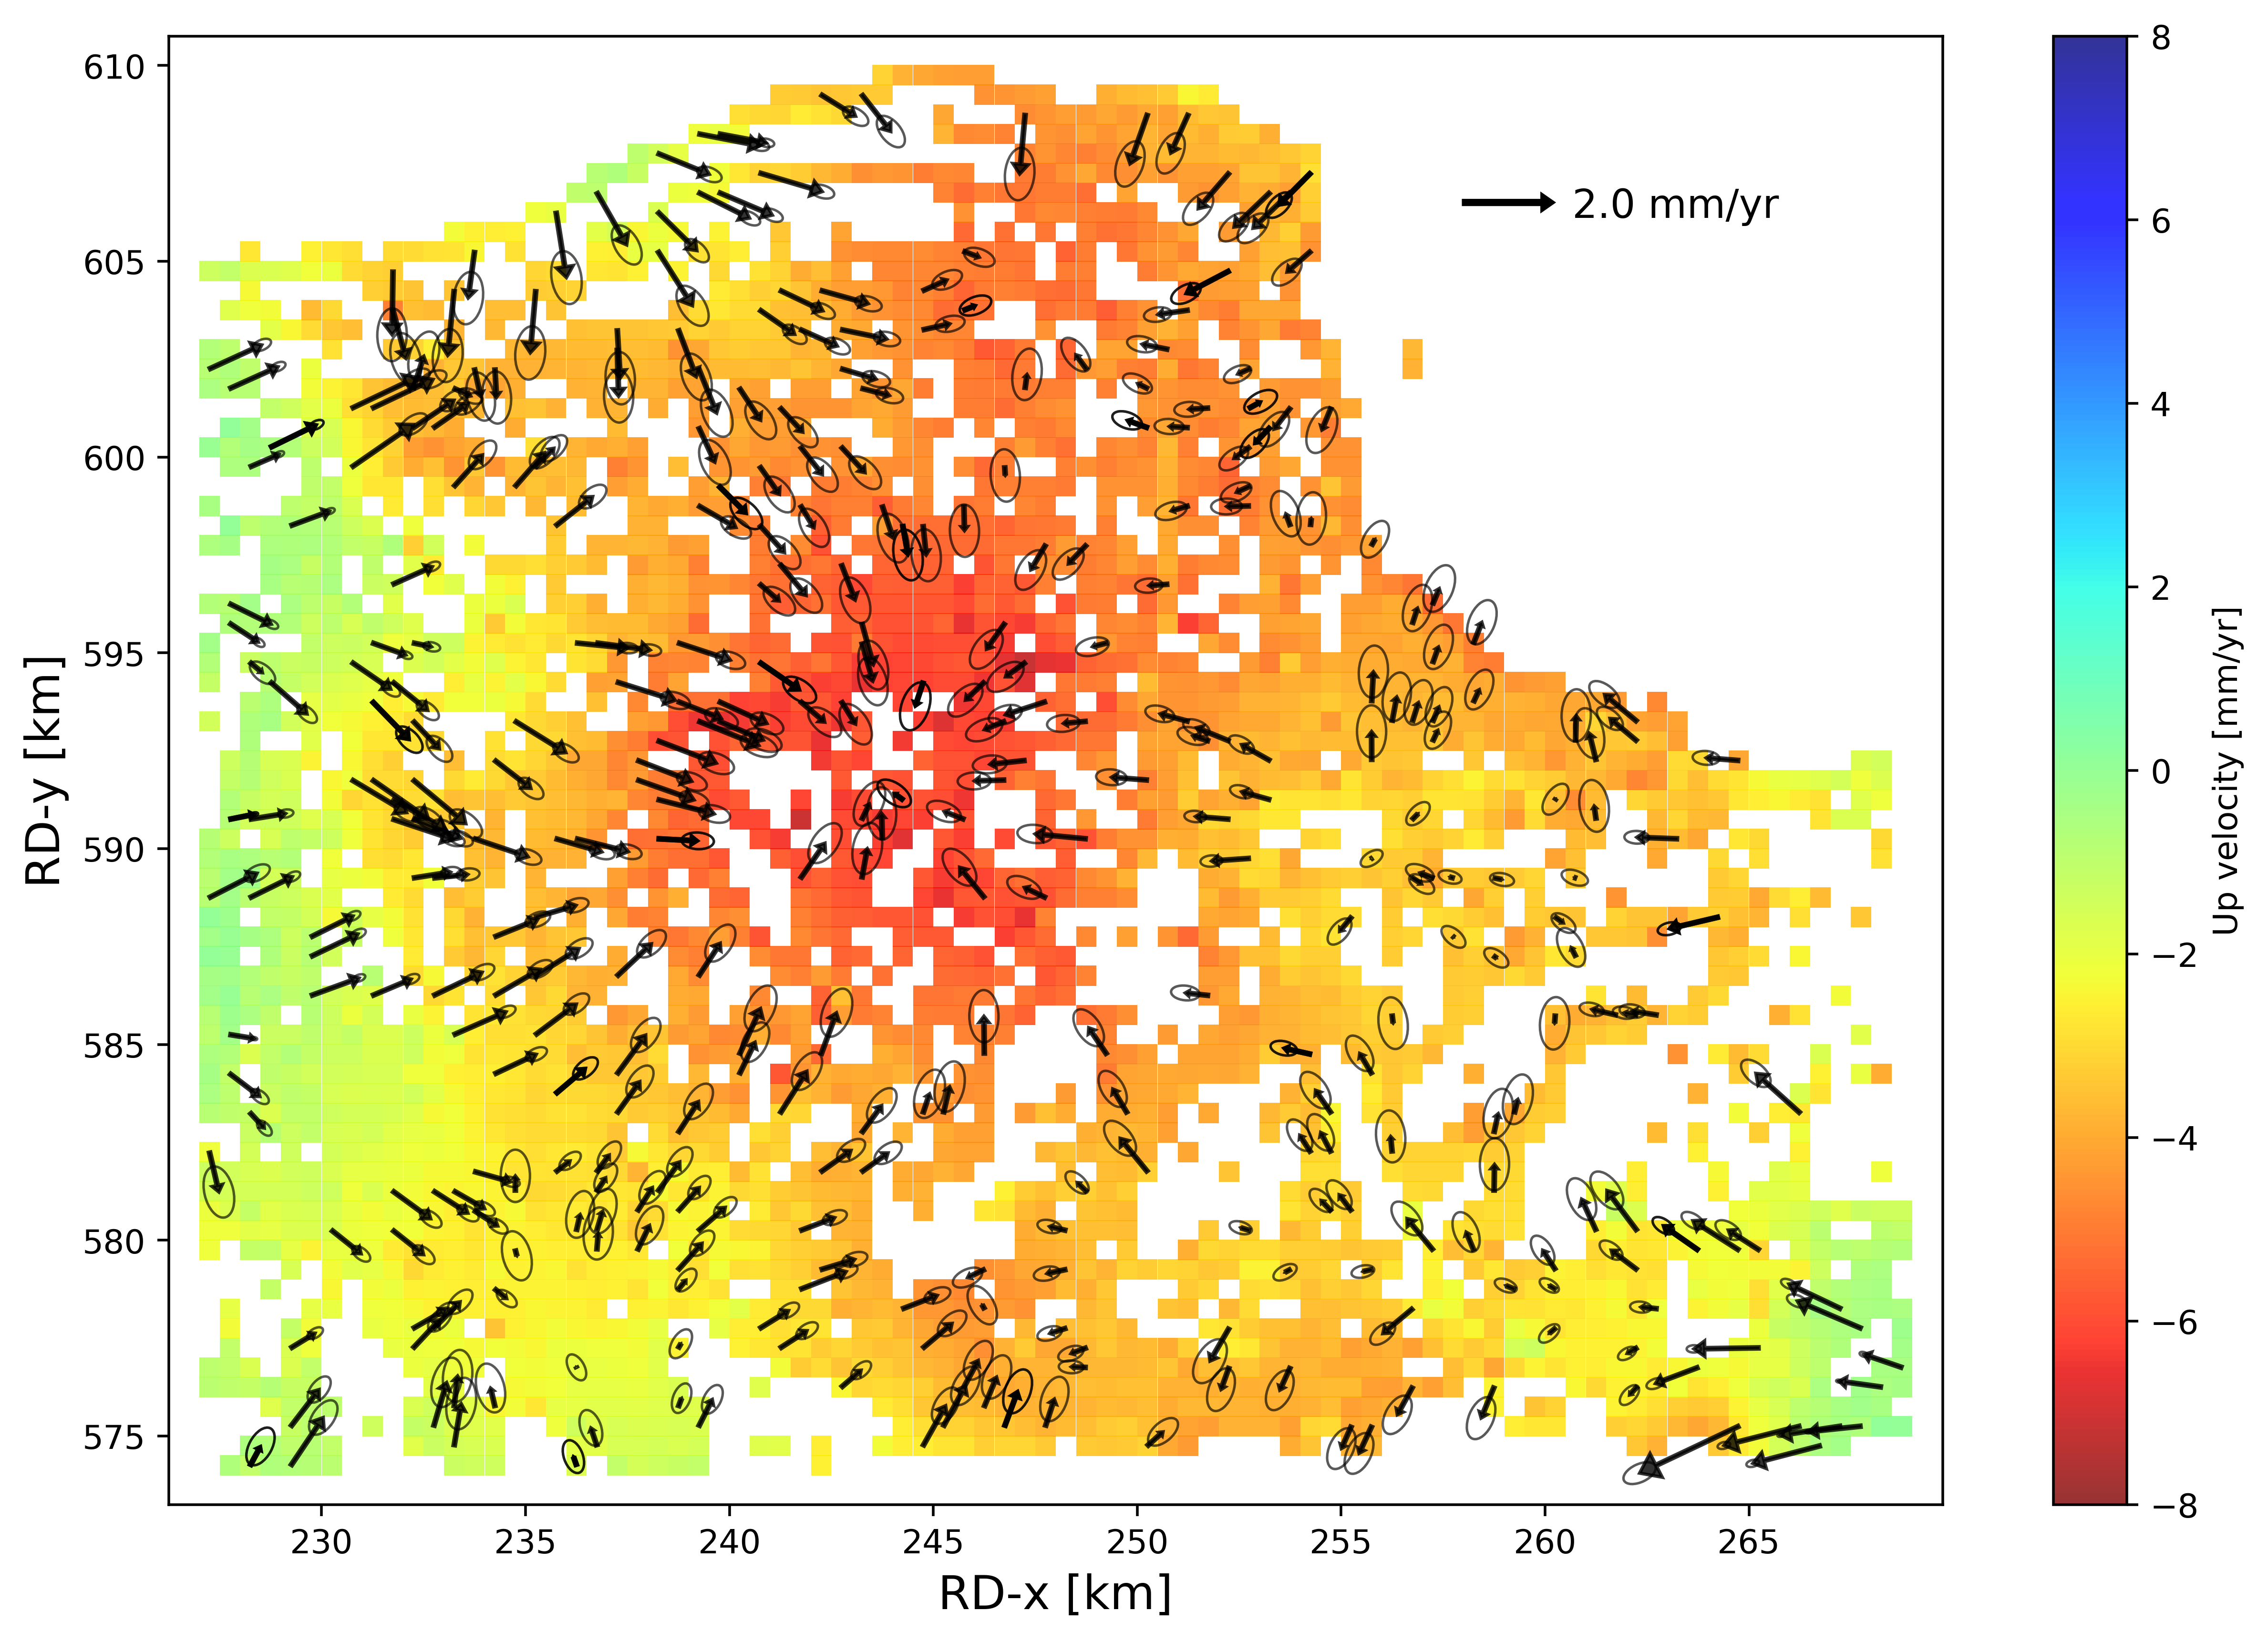

In [30]:


fig,ax = plt.subplots(figsize=(12, 8), dpi = 500)
sc = plt.scatter(
    x_rum, y_rum,
    c=up_est,
    s=37.7,
    alpha=0.8,
    cmap='jet_r',
    vmin=-up_v_max,
    vmax=up_v_max,
    marker='s',             # Square markers
    linewidths=0     # removes the edge 
)
plt.colorbar(sc, label = 'Up velocity [mm/yr]')
for k in range(int((nr_vectors_plot))):
        x_coord_rum = x_rum[random_idx[k]]
        y_coord_rum = y_rum[random_idx[k]]
        east_rum = east_est[random_idx[k]]*1000 # from meters to mm
        north_rum = north_est[random_idx[k]]*1000 # from meters to mm

        # get the var-cov matrix of the east and north component
        Q_en = np.array([
                        [var_east[random_idx[k]]* scaling, covar_en[random_idx[k]] * scaling],
                        [covar_en[random_idx[k]] * scaling, (var_north[random_idx[k]]) * scaling]
                ])

        # Compute the length of the vector
        trans_displ_rum = np.sqrt(east_rum**2 + north_rum**2)
        
        # Plot the vector
        ax.arrow(x_coord_rum, y_coord_rum, east_rum, north_rum, length_includes_head = 'true', #edgecolor='blue', facecolor = 'None',
                        color = 'black', alpha = 0.8, width = 60, head_length = 1/6*(np.sqrt(trans_displ_rum**2)), 
                        head_width = 1/4*(np.sqrt(trans_displ_rum**2))
                        )
        

        # Plot the error ellipse
        eigenvals, eigenvecs = np.linalg.eigh(Q_en)

        # Sort eigenvalues and associated eigenvectors
        order = eigenvals.argsort()[::-1]
        eigenvals, eigenvecs = eigenvals[order], eigenvecs[:, order]

        # Compute angle in degrees
        angle = np.degrees(np.arctan2(*eigenvecs[:,0][::-1]))

        # Width and height are 2*sqrt(eigenvalues)*n_std
        width, height = n_std_plot * np.sqrt(eigenvals)
        
        ellip = Ellipse(xy=(x_coord_rum + east_rum, y_coord_rum + north_rum), 
                        width=width, height=height, angle=angle,
                        ec='black',
                        alpha=0.65,
                        fc='None',
                        linewidth=0.75)
        ax.add_patch(ellip)

        
ax.set_xlim(np.min(x_rum)-1000, np.max(x_rum)+1000)
ax.set_ylim(np.min(y_rum)-1000, np.max(y_rum)+1000)
ax.xaxis.set_major_formatter(formatter)  
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel('RD-x [km]', fontsize = 14)
ax.set_ylabel('RD-y [km]', fontsize = 14)

if plot_streetmap:
        cx.add_basemap(ax, crs='epsg:28992', source=cx.providers.OpenStreetMap.Mapnik, zoom=14)

# Add scale vector
scale_length = 2*10**-3 # 2 mm as example
scale_vector = scale_length * scaling  

# Coördinaten for the scale vector
scale_x = 258000
scale_y = 606500

ax.arrow(scale_x, scale_y, scale_vector, 0, length_includes_head=True,
        color='black', width=100, head_length=1/8 * scale_vector, head_width=400)
ax.text(scale_x + scale_vector + 3000, scale_y + 400, f'{scale_length*1000} mm/yr', 
        fontsize=12, color='black', ha='center', va='top')



